<a href="https://colab.research.google.com/github/nghiagithub318/image-captioning-with-Resnet18-and-transformer-decoder/blob/main/ver3_of_image_captioning_convert_to_vietnamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_colwidth', None)
from tqdm.auto import tqdm
import pickle 
import random
import os
import tensorflow as tf

In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Download dataset

# Define parameter

In [158]:
batch_size = 64
embedding_size = 1280


In [159]:
# Download image files


image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2017.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [160]:
import json

annotation_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_train2017.json'

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

annotation_val_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_val2017.json'

with open(annotation_val_file, 'r') as f:
    annotations_val = json.load(f)

annotation_test_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_test2017.json'

with open(annotation_test_file, 'r') as f:
    annotations_test = json.load(f)

In [161]:
annotations['images'][:1]


[{'license': 2,
  'file_name': '000000535668.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000535668.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-19 18:06:56',
  'flickr_url': 'http://farm4.staticflickr.com/3061/2442277392_49eb08cb2f_z.jpg',
  'id': 535668}]

In [162]:
annotations['annotations'][:1]


[{'image_id': 157656,
  'caption': 'Người đàn ông đang đánh tennis ngoài sân.',
  'id': 4990}]

# Group all captions together having the same image ID.


In [163]:
import collections

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [164]:
image_path_to_caption_val = collections.defaultdict(list)
for val in annotations_val['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption_val[image_path].append(caption)

In [165]:
image_path_to_caption_test = collections.defaultdict(list)
for val in annotations_test['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption_test[image_path].append(caption)

# convert to dataframe

In [166]:
df_train = (pd.DataFrame.from_dict(image_path_to_caption, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 
df_val = (pd.DataFrame.from_dict(image_path_to_caption_val, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 

In [167]:
df_train.head()

,image,caption
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>
2,/content/train2017/000000157656.jpg,<start> Một cầu thủ tennis đang vung vợt tennis đỡ bóng. <end>
3,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng. <end>
4,/content/train2017/000000157656.jpg,<start> Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng. <end>


In [168]:
df_test = (pd.DataFrame.from_dict(image_path_to_caption_test, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 
df_test.head()


,image,caption
0,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đẩy trên quả banh. <end>
1,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đầu lên quả bóng đá hít đất. <end>
2,/content/train2017/000000205086.jpg,<start> Một cậu bé đang hít đất đầu trên quả banh trên cỏ. <end>
3,/content/train2017/000000205086.jpg,<start> Một cậu bé đang hít đất cùng quả bóng và một cậu bé đang quan sát. <end>
4,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đẩy trên một quả bóng đá. <end>


In [169]:
print(len(df_test))

1155


In [170]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths.copy()
print(len(train_image_paths))

2695


In [171]:
# train_image_paths[:5]

In [172]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  # print(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
  # print(img_name_vector)

In [173]:
# print(len(train_captions))
# print(len(img_name_vector))

# Import data

# show image

In [174]:
# cap['image'].iloc[1]

In [175]:
cap = pd.concat([df_train,df_val])
print(len(cap))

18101


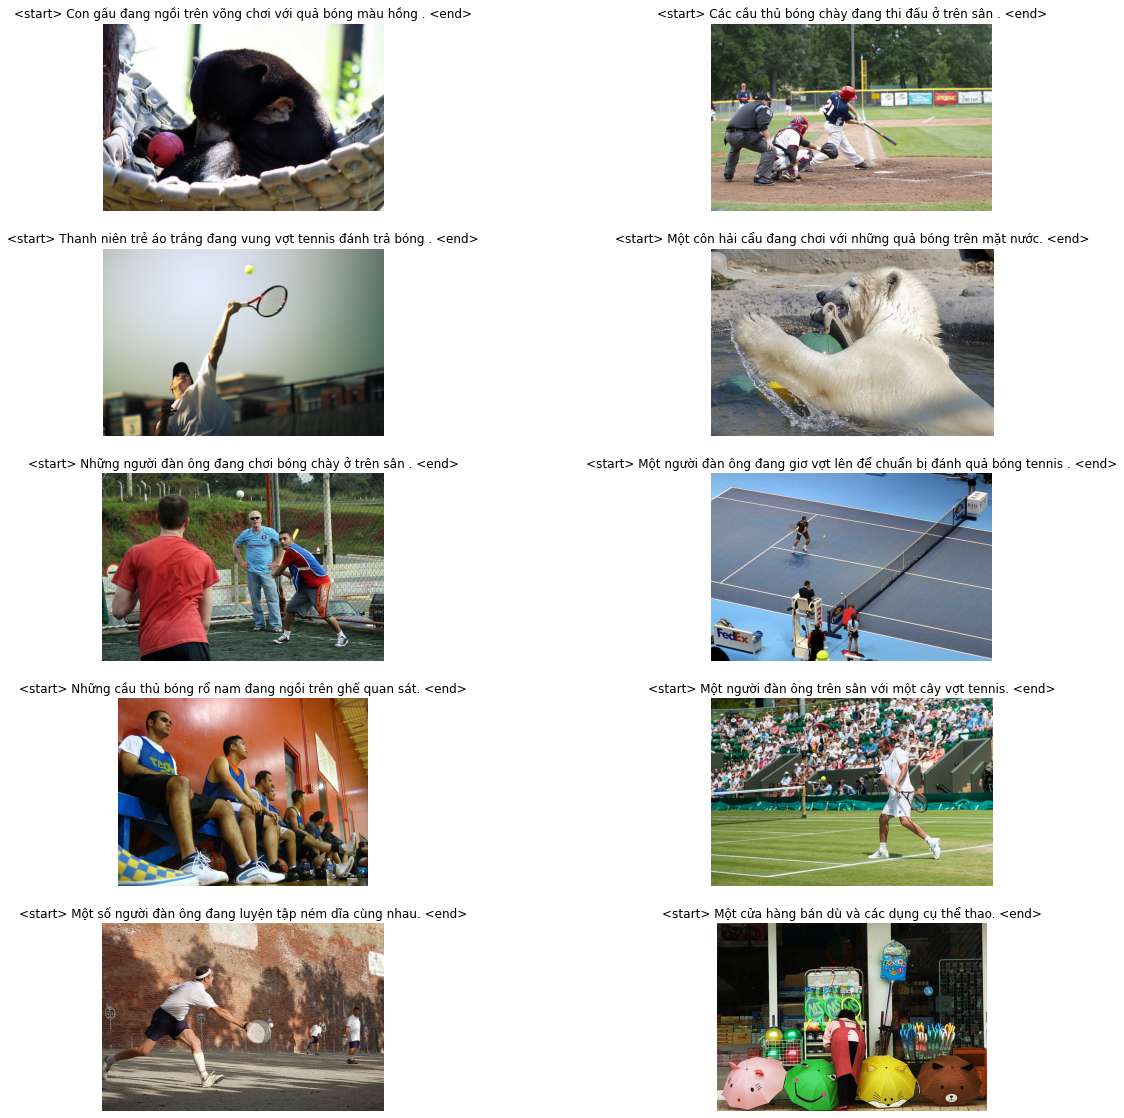

In [176]:
import cv2
import glob
figure = plt.figure(figsize = (20,20))
for i in range(10):
  plt.subplot(5,2,i+1)
  idx = np.random.randint(0,1000)
  images = cv2.imread(cap['image'].iloc[idx])
  plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(df_train['caption'].iloc[idx])
plt.show()

# Preprocessing
1. lower case and remove word not isalpha split 
2. padding 

In [177]:
def remove_1_length_word(x):
  list = []
  for i in x:
    if len(i)> 1:
      list.append(i)
  return list

In [178]:
import re
def standardize(inputs):
  inputs = inputs.lower()
  # re.sub(r'\b\S*[AĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴA-Z]+\S*\b'
  inputs = re.sub(r'\.!?( *)', ' ', inputs)
  inputs = re.sub(r'[0 - 9]', ' ', inputs)

  return inputs
  

In [179]:
max_sequence_len = 35

In [180]:
def preprocess(df):
  # df['caption_clean'] = df['caption'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
  df = df.copy()
  df['caption_clean'] = df['caption'].apply(standardize)
  df['caption_clean'] = df['caption_clean'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
  df['caption_clean'] = df['caption_clean'].apply(remove_1_length_word)
  df['lens'] = df.caption_clean.apply(lambda x: len(x))
  pad = '<pad>'
  df['caption_clean'] = df.caption_clean.apply(lambda x: x + (max_sequence_len - len(x)) * [pad])
  df = df.drop(labels = 'lens', axis = 1)
  return df
df_all = preprocess(pd.concat([df_train, df_val,df_test]))
df = preprocess(cap)
df_test = preprocess(df_test)


In [181]:
print(len(df_test))
print(len(df))

1155
18101


## Create dictionary


In [182]:

world_dict = df_all['caption_clean'].apply(lambda x: ' '.join(x)).str.cat(sep = ' ').split(' ')
len(world_dict)

673960

In [183]:
from collections import Counter
world_dict = Counter(world_dict)
world_dict = sorted(world_dict,key = world_dict.get,reverse = True)
print(world_dict)
word_to_idx = {word:idx for (idx,word) in enumerate(world_dict)}
idx_to_word = {idx:word for (idx,word) in enumerate(world_dict)}
df['token'] = df['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df_test['token'] = df_test['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])

#vocab size
print(len(word_to_idx))
vocab_size = len(word_to_idx)

['<pad>', '<start>', '<end>', 'bóng', 'đang', 'tennis', 'người', 'một', 'trên', 'sân', 'đánh', 'chày', 'thủ', 'cầu', 'ông', 'đàn', 'vợt', 'động', 'viên', 'quả', 'vận', 'cầm', 'nữ', 'để', 'chơi', 'đấu', 'thi', 'phụ', 'nam', 'áo', 'bị', 'đứng', 'chuẩn', 'gậy', 'ném', 'đá', 'và', 'những', 'bé', 'vung', 'hai', 'trẻ', 'lên', 'đứa', 'trong', 'của', 'cậu', 'đỡ', 'các', 'tay', 'trận', 'trắng', 'với', 'trước', 'ngoài', 'theo', 'ra', 'hình', 'phía', 'ảnh', 'cao', 'tập', 'bắt', 'luyện', 'dõi', 'về', 'cỏ', 'nhảy', 'xoay', 'diễn', 'con', 'dùng', 'phát', 'cô', 'trả', 'khán', 'cùng', 'giơ', 'cái', 'giả', 'sát', 'xanh', 'cú', 'nhau', 'quan', 'cạnh', 'tranh', 'đen', 'găng', 'chạy', 'bước', 'đội', 'đưa', 'trời', 'đỏ', 'mặc', 'số', 'nhà', 'vào', 'sau', 'tới', 'thực', 'hiện', 'chân', 'nhóm', 'bằng', 'bay', 'ngồi', 'tài', 'đông', 'giao', 'trọng', 'chó', 'tác', 'chấp', 'dưới', 'gôn', 'đeo', 'rổ', 'khi', 'nghiêng', 'gái', 'môn', 'màu', 'đi', 'đất', 'vừa', 'sút', 'biển', 'đảo', 'thành', 'đường', 'bãi', 'biên'

In [184]:
print(len(df))

18101


In [185]:
print(len(df_test))

1155


In [186]:
df.head(2)

,image,caption,caption_clean,token
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>,"[<start>, người, đàn, ông, đang, đánh, tennis, ngoài, sân, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 6, 15, 14, 4, 10, 5, 54, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>,"[<start>, một, vận, động, viên, tennis, đang, vung, vợt, đánh, bóng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 7, 20, 17, 18, 5, 4, 39, 16, 10, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [187]:
# from sklearn.model_selection import train_test_split
# df = df.sort_values('image')
# train, test = train_test_split(df, random_state = 42, test_size = 0.2)
train = df
test = df_test
print(len(train), train['image'].nunique())
print(len(test), test['image'].nunique())

18101 3619
1155 231


# Image ==> Resnet==> {imagename : image_emb}

In [188]:
from PIL import Image
class extractFeatureResnet():
  def __init__(self,data):
    self.data = data
    self.scaler = transforms.Resize([224,224])
    self.normalizer = transforms.Normalize(
        mean  = [0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    self.transform = transforms.ToTensor()
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    #take image from file image_path
    # print('check 1 ')
    image_name = self.data.iloc[idx]['image']
    # print('check 2 ')
    img = Image.open(image_name).convert('RGB')
    img =  self.normalizer(self.transform(( self.scaler(img))))
    if img.shape[0] == 1 :
      print(img.shape)
    return image_name, img

# take 1000

In [189]:
train_unique_image = train[['image']].drop_duplicates()
# train_unique_image = train_unique_image[:1000]
train_extract = extractFeatureResnet(train_unique_image)
train_loader = DataLoader(train_extract, batch_size = 1, shuffle = False)

test_unique_image = test[['image']].drop_duplicates()
# test_unique_image = test_unique_image[:1000]
test_extract = extractFeatureResnet(test_unique_image)
test_loader = DataLoader(test_extract, batch_size = 1, shuffle = False)

In [190]:
for (image_name, img) in train_loader:
    print(image_name)
    print(img.shape)
    break
    

('/content/train2017/000000157656.jpg',)
torch.Size([1, 3, 224, 224])


In [191]:
train_unique_image.head() #du lieu idx va image name

,image
0,/content/train2017/000000157656.jpg
10,/content/train2017/000000049860.jpg
20,/content/train2017/000000053702.jpg
30,/content/train2017/000000487198.jpg
40,/content/train2017/000000487204.jpg


# Resnet model


In [192]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# resnet18 = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT).to(device)
# resnet18.eval()
# resnet_18_layer_4 = resnet18._modules.get('layer4')
# for layername, layer in resnet18._modules.items():
#     print(layername, layer)

In [193]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_img = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)



In [194]:
model_img.eval()
model_img_layer_4 = model_img._modules.get('features')#[0:-1]
# print(model_img_layer_4)
# class fine_tune_model(nn.Module):
#     def __init__(self, model_img_layer_4):
#         super(fine_tune_model, self).__init__()
#         self.model_img_layer_4 = model_img_layer_4
#         self.conv = nn.LazyConv2d(512, 1, padding= 'same')
#     def forward(self, x):
#         x = self.model_img_layer_4(x)
#         x = self.conv(x)
#         return x
# resnet_18_layer_4  = fine_tune_model(model_img_layer_4).to(device)

In [195]:
from torchsummary import summary
summary(model_img_layer_4, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [196]:
def get_vector(t_img):
  my_emb = torch.zeros(1,embedding_size,7,7)
  t_img = torch.autograd.Variable(t_img).to(device)
  def hook(model, input, output):

    my_emb.copy_(output.data)
  h = model_img_layer_4.register_forward_hook(hook)
  model_img_layer_4(t_img)
  h.remove()
  # print(my_emb)
  return my_emb


In [197]:
img_emb = {image_name[0]: get_vector(image) for image_name, image in tqdm(train_loader) }

  0%|          | 0/3619 [00:00<?, ?it/s]

In [198]:
img_emb_test = {name[0]:get_vector(img) for name , img in tqdm(test_loader)}
# print(img_emb_test)

  0%|          | 0/231 [00:00<?, ?it/s]

# Is in

In [199]:
# train = train[train['image'].isin(img_emb.keys())]
# test = test[test['image'].isin(img_emb_test.keys())]
# print(len(test))
# print(len(train))

In [200]:
# test

In [201]:
with open('train_img_emb.pkl', 'wb') as f: #wb writing as binary
  pickle.dump(img_emb, f)
with open('valid_img_emb.pkl', 'wb') as f:
  pickle.dump(img_emb_test,f)


In [202]:
# del img_emb , img_emb_test

# Create dataset for Transformer model

In [203]:
class image_emb_seq_dataset():
  def __init__(self,data, file_path ):
    self.data = data
    self.emb_dict = pd.read_pickle(file_path)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    seq = self.data.iloc[idx]['token']
    target = seq[1:] + [0] #teacher forcing
    image_name = self.data.iloc[idx]['image']
    # print('image_name',image_name)
    img_emb = self.emb_dict[image_name]
    # print('img_emb :',img_emb.shape)
    # print(img_emb)
    #convert image from (1,512,7,7) => (1,49,512)
    img_emb = torch.permute(img_emb, (0,2,3,1))
    img_emb = img_emb.view(img_emb.size(0),-1,img_emb.size(3))
    return torch.tensor(seq), torch.tensor(target),img_emb

In [204]:
file_path = 'train_img_emb.pkl'
train_image_seq = DataLoader(image_emb_seq_dataset(train,file_path), batch_size = batch_size, shuffle = True)
file_path = 'valid_img_emb.pkl'
test_image_seq = DataLoader(image_emb_seq_dataset(test,file_path), batch_size = batch_size, shuffle = True)


In [205]:
for ( seq, target,image) in test_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    # print(image)
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([64, 1, 49, 1280])


# Create transformer model

## Position encoding

In [206]:
import math
class position_encoding(nn.Module):
  def __init__(self,d_model = 512, max_len = max_sequence_len, dropout = 0.1):
    super().__init__()

    self.dropout = nn.Dropout(dropout)
    
    pe = torch.zeros(max_len , d_model) # (33,512)
    pos = torch.arange(0,max_len).unsqueeze(1) #(33,1)
    div_term = torch.exp(torch.arange(0,d_model, 2 ).float() * (-math.log(10000.0) / d_model) ) #256
    pe[:,::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)
    pe = pe.unsqueeze(0) # (1,32,512)
    # print('pe ' ,pe.shape)
    self.register_buffer('pe', pe)

  def forward(self,x):
    if x.size(0) > self.pe.size(0):
      self.pe = self.pe.repeat(x.size(0),1,1)
    self.pe = self.pe[:x.size(0),:,:]
    return self.dropout(self.pe +x) 


# Transformer Decoder

In [207]:
class Imagecaptionmodel(nn.Module):
  def __init__(self , vocab_size = vocab_size, embedding_size = embedding_size, max_len =max_sequence_len  , n_head = 16, num_decoder_layer = 4):
    super().__init__()
    self.position_encoding =  position_encoding(d_model = embedding_size)

    self.transformer_decoder_layer  = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer,num_layers = num_decoder_layer )
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.FC = nn.LazyLinear(vocab_size)
    self.initweights()
    self.embedding_size = embedding_size
  def initweights(self):
    self.embedding.weight.data.uniform_(-0.1,0.1)
    self.FC.weight.data.uniform_(-0.1,0.1)
    self.FC.bias.data.zero_()
  def create_mask(self, seq):
      'create mask for mask attention'
      attention_mask  = torch.ones(seq.size(1), seq.size(1))
      # print('attention_mask ',attention_mask.shape)
      attention_mask  = torch.tril(attention_mask)
      attention_mask = attention_mask.masked_fill(attention_mask == 0 , float('-inf')).masked_fill(attention_mask == 1, 0)

      pad_mask = seq.masked_fill(seq == 0 , float(0.0)).masked_fill(seq > 0  , float(1.0)) # 
      pad_mask_bool  = seq == 0 
      return attention_mask, pad_mask ,pad_mask_bool
  def forward(self,seq, image_embedding):
    image_embedding  = image_embedding.permute(1,0,2) # 49,32,512
    # print(image_embedding)
    # print('create_mask ')
    # print('seq', seq.shape)
    x = self.embedding(seq) * math.sqrt(self.embedding_size)
    x = self.position_encoding(x) # 32, 33 512
    x = x.permute(1,0,2) # (seqlen, batchsize, embedding)
    # print('x permute', x.shape)
    # print('image_embedding shape ', image_embedding.shape)
    attention_mask, pad_mask ,pad_mask_bool = self.create_mask(seq)
    attention_mask, pad_mask ,pad_mask_bool = attention_mask.to(device), pad_mask.to(device) ,pad_mask_bool.to(device)
    # print('done embedding x shape ',x.shape )
    # print('attention_mask, pad_mask ,pad_mask_bool' , attention_mask.shape, pad_mask.shape ,pad_mask_bool.shape)
    
    #model nhan vao tgt: (seq_len, batch_size, embddingsize)
    #memory (input_seq_len, batch_size, embeddingsize)
    # tgt_key_padding_mask = (N,T)
    # tgt_mask = (T,T)
    # memory_mask: (T, S)
    x = self.transformer_decoder(memory = image_embedding,
                                 tgt = x , 
                                 tgt_mask = attention_mask,
                                 tgt_key_padding_mask = pad_mask_bool,
                                 ) #(T, N ,E) (33,32,512)
    # print('out transformer :',x.shape)
    out = self.FC(x)
    return out , pad_mask


# Print shape model

In [208]:
from torchsummary import summary
for ( seq, target,image) in train_image_seq:
    print(seq.shape)
    image = image.squeeze(1).to(device)
    seq = seq.to(device)
    print('image', image.shape)
    print(torch.max(seq))
    print(target.shape)
    print(image.shape)
    model = Imagecaptionmodel().to(device)
    print('output shape  :',model(seq,image)[0].shape)
    # attention_mask, pad_mask ,pad_mask_bool torch.Size([33, 33]) torch.Size([32, 33]) torch.Size([32, 33])
    # summary(model, seq,image )
    break

torch.Size([64, 35])
image torch.Size([64, 49, 1280])
tensor(616, device='cuda:0')
torch.Size([64, 35])
torch.Size([64, 49, 1280])
output shape  : torch.Size([35, 64, 1365])


In [209]:
# model = Imagecaptionmodel()

In [210]:
# # FloatTensor containing pretrained weights
# weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
# embedding = nn.Embedding(100,10)
# # Get embeddings for index 1
# temp  = torch.randint(32,(32,33))
# input = torch.LongTensor([1])
# embedding(temp).shape

# Train Loop

In [214]:
EPOCHS = 10
ict_model= Imagecaptionmodel( n_head = 20, num_decoder_layer = 6).to(device)
optimizer = torch.optim.Adam(ict_model.parameters(), lr = 2e-6)
criterion = nn.CrossEntropyLoss(reduction = 'none')
min_val_loss = (np.float('Inf'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=1, verbose = True)

In [215]:
ict_model  = torch.load('Bestmodel')
torch.cuda.empty_cache()

In [216]:
for epoch in range(1,EPOCHS+1):
    total_loss_epoch_train = 0
    total_loss_epoch_val = 0
    total_words_train = 0
    total_words_val = 0 
    ict_model.train()
    with tqdm(total=len(train_image_seq) , unit = 'batch') as pbar:
      for (seq, target, image) in (train_image_seq):
        optimizer.zero_grad()

        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        loss_final.backward()
        optimizer.step()
        total_loss_epoch_train += loss_pad_mask.sum().detach().item()
        total_words_train += pad_mask.sum().detach().item()

        pbar.set_description(desc= f'epoch {epoch} loss={total_loss_epoch_train / total_words_train:0.4f}')
        pbar.update(1) 
       # print(total_loss_epoch_train)
       # print(total_words_train)
       #  print('TRAIN EPOCH : {} , Loss : {}'.format(epoch, total_loss_epoch_train / total_words_train))
      total_loss_epoch_train = total_loss_epoch_train / total_words_train
      # print('TRAIN EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_train))
    ict_model.eval()
    with torch.no_grad():
      for (seq, target, image) in test_image_seq:
        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        total_loss_epoch_val += loss_pad_mask.sum().item()
        total_words_val += pad_mask.sum().item()
      total_loss_epoch_val = total_loss_epoch_val / total_words_val
      print('TEST EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_val))
      if min_val_loss > total_loss_epoch_val :
        print('writing model at epoch : ', epoch)
        torch.save(ict_model, './Bestmodel')
        min_val_loss = total_loss_epoch_val
      scheduler.step(total_loss_epoch_val)



  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 1 , Loss : 1.1782932888046522
writing model at epoch :  1


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 2 , Loss : 1.1782932947996467


  0%|          | 0/283 [00:00<?, ?batch/s]

KeyboardInterrupt: ignored

In [ ]:
# torch.save(ict_model, './Bestmodel')
del ict_model

In [217]:
#load model
# model_inference = torch.load('/content/drive/Shareddrives/Nơi chia sẻ kiến thức của Nguyên và Nghĩa/Unity/Bestmodel')

model_inference = torch.load('./Bestmodel')
start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

1 2 0


# Generate caption

In [218]:
valid_img_emb = pd.read_pickle('valid_img_emb.pkl')

['các', 'cầu', 'thủ', 'bóng', 'đá', 'đang', 'thi', 'đấu', 'trên', 'sân', '<end>']


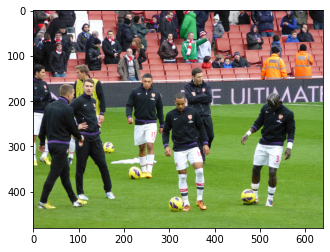

In [224]:
import random

def gen_caption(k , image_name):
  img = Image.open(image_name)

  plt.imshow(img)
  img_emb = valid_img_emb[image_name] # 1 512 7 7 
  img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
  # print(img_emb.shape)
  img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
  # print('c1')
  caption = []
  seq = [pad] * max_sequence_len 
  seq[0] = start
  seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
  img_emb = img_emb.to(device)
  # print('seq : ',seq.shape)
  # print('img_emb : ',img_emb.shape)
  
  for i in range(0,max_sequence_len-1):
    out , _ = model_inference(seq, img_emb) # 33, 32, 10000
    # print('out :', out.shape)
    pred = out[i, 0, :]
    # print('pred : ', pred.shape)

    # pred = pred.squeeze(1)
    # print('pred : ', pred.shape)
    indicies = torch.topk(pred , k ).indices.tolist()
    # print(indicies)
    values = torch.topk(pred, k).values.tolist()
    # print(values)
    token = random.choices(indicies, values)[0] # 
    seq[:, i+1] = token
    # print('seq' , seq)
    if token == pad:
      break
    word = idx_to_word[token]
    caption.append(word)
    # break
  return caption
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))


['một', 'nữ', 'vận', 'động', 'viên', 'tennis', 'đang', 'nhảy', 'lên', 'để', 'đánh', 'bóng', '<end>']


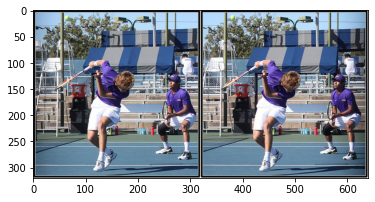

In [225]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))


['một', 'nữ', 'thủ', 'môn', 'đang', 'bay', 'người', 'để', 'bắt', 'bóng', '<end>']


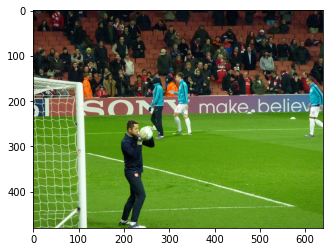

In [226]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))


['một', 'nữ', 'vận', 'động', 'viên', 'tennis', 'đang', 'nhảy', 'lên', 'để', 'đánh', 'bóng', '<end>']


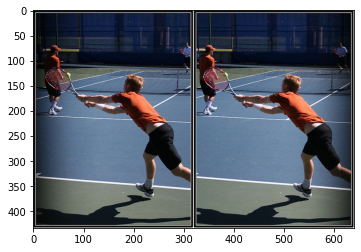

In [227]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))


# Bleu score

In [220]:
print(len(test_unique_image))

231


In [221]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider
!pip install pycocoevalcap
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/231 [00:00<?, ?image/s]

{'testlen': 2600, 'reflen': 2635, 'guess': [2600, 2369, 2138, 1907], 'correct': [1868, 1130, 696, 467]}
ratio: 0.9867172675518077

 ********** BLEU-4 ********** 
 [0.7088547469967853, 0.5775800466354735, 0.47496310668367936, 0.4011205262280533]

 ********** ROUGH ********** 
 0.5896514296477289

 ********** CIDER (NOT CIDAr-D) ********** 
 1.1264184282855882


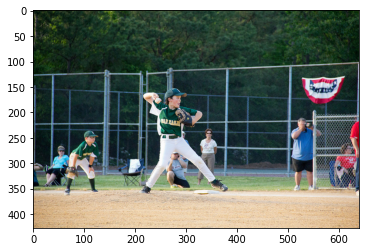

In [222]:
# captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
#ref hypo
gts_dict , ref_dict = {} , {}
dem = 0
with tqdm(total=len(test_unique_image['image']) , unit = 'image') as pbar:
 for i, image_name in enumerate(test_unique_image['image']):
  # print(image_name)
  # image = valid_img_emb[image]
  # image_name = image_name[0]
  list_real_caption = [ ' '.join(i.split()[1:-2]) for i in image_path_to_caption_test[image_name]]
  # if len(list_real_caption) ==0:
  #   continue
  result = gen_caption(1, image_name)
  result = ' '.join(result[:-1])
  ref = [i.lower() for i in list_real_caption]
  test_sen = result#.split()
  # print('list_real_caption :',list_real_caption)
  # print(len(ref))
  if len(ref) == 0: 
    # print('list_real_caption: ', list_real_caption)
    # print('ref' , ref)
    # print('image_path_to_caption[image_name]: ',image_path_to_caption[image_name])
    dem +=1
  else:
    # print(len(test))
    # print('test :',test)
    # print('ref :',ref)
    # print(blue_score)
    gts_dict[image_name] = ref
    ref_dict[image_name] = [test_sen]

    # blue_score_list.append(blue_score)
    
  # pbar.set_description(f'i =  :  {i} || BLEU score ={np.sum(blue_score_list)/len(blue_score_list)}')
  pbar.update(1) 
  # break
b, r, c = score(gts_dict, ref_dict)
print('\n ********** BLEU-4 ********** \n', b)
print('\n ********** ROUGH ********** \n', r)
print('\n ********** CIDER (NOT CIDAr-D) ********** \n', c)
torch.save(model_inference, './Bestmodel_{}'.format(c))
  # print(blue_score)

In [223]:
# print('BlEU score in the test set :' ,np.sum(blue_score_list)/len(blue_score_list))

# Cai tien
## Thay preprocess cua phu
## Mabe cho word to vect
## Load and save model cho vao api cua tung